In [1]:
import pandas as pd
import numpy as np

# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import matplotlib.pyplot as plt

import urllib
import os
import requests
import zipfile
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:

path = 'Clean_DataSet.csv'
data = pd.read_csv(path).iloc[:,1:]
data.columns
     

Index(['CAMIS', 'DBA', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE',
       'SCORE', 'GRADE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'geometry', 'FoodDOSite_Within_300m', 'SubwayWithin_300m', 'BBL',
       'Rodent_Freq2021', 'CT2020', 'NTAName', 'NTA2020', 'CDTA2020',
       'CDTANAME', 'RatioIncome', 'Population', 'mobile', 'citibike', 'sr311',
       'subway', 'taxi', 'twitter', 'working', 'residential',
       'VIOLATION CODE'],
      dtype='object')

In [3]:

cuision = dict()
cuision['Asian/Asian Fusion'] = ['Chinese/Cuban','Chinese/Japanese','Indonesian','Southeast Asian','Thai','Bangladeshi','Filipino']
cuision['Fuision'] = ['Asian/Asian Fusion','Fusion','New American']
cuision['Korean/Japanese'] = ['Korean','Japanese']
cuision['Indian'] = ['Indian']
cuision['Chinese'] = ['Chinese']
cuision['Central Asian'] = ['Afghan','Pakistani','Middle Eastern','Iranian','Mediterranean','Turkish']
cuision['Bakery/Desserts'] = ['Bagels/Pretzels','Bakery Products/Desserts','Donuts','Basque','Pancakes/Waffles','Frozen Desserts','Nuts/Confectionary']
cuision['Beverages'] = ['Bottled Beverages','Coffee/Tea']
cuision['Pizza/Hotdogs/Chicken'] = ['Pizza','Hotdogs','Hamburgers','Chicken','Hotdogs/Pretzels']
cuision['African'] = ['African','Ethiopian','Lebanese','Moroccan','Egyptian']
cuision['Latin American'] = ['Peruvian','Mexican','Brazilian','Caribbean','Latin American','Chilean']
cuision['American'] = ['American','Tex-Mex','Creole','Cajun','Californian','Southwestern','Soul Food','Hawaiian','Creole/Cajun']
cuision['Vegan/Fruit'] = ['Fruits/Vegetables','Juice, Smoothies, Fruit Salads','Salads','Sandwiches','Soups/Salads/Sandwiches',
                          'Vegan','Vegetarian','Soups','Sandwiches/Salads/Mixed Buffet']
cuision['Protein'] = ['Steakhouse','Barbecue','Seafood',]
cuision['European'] = ['Armenian','Czech','Polish','Scandinavian','Greek','Eastern European','Irish','Russian','English','Continental']
cuision['South European'] = ['French','Spanish','Italian','German','Tapas','Portuguese','New French']
cuision['Other'] = ['Other','Not Listed/Not Applicable']
cuision['Jewish/Kosher'] = ['Jewish/Kosher']
cuision['Australian'] = ['Australian']

In [4]:

cuision_new = []
for cui in data['CUISINE DESCRIPTION'].values:
    add = ''
    for k,v in cuision.items():
        if cui in v:
            add = add + k
    cuision_new.append(add)

data['CUISINE DESCRIPTION'] = cuision_new

In [5]:
LatList = data.Latitude.tolist()
LonList = data.Longitude.tolist()
data['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(data))]
geodata = gpd.GeoDataFrame(data)

geodata = geodata.set_crs(epsg=4326)
geodata = geodata.to_crs(epsg=2263)

In [6]:

urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'geometry']]
# Reproject shapefile
zips = zips.to_crs(epsg = 2263)

zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [7]:
grade_viz = geodata[['GRADE','geometry']].sjoin(zips, op='within', how='inner')

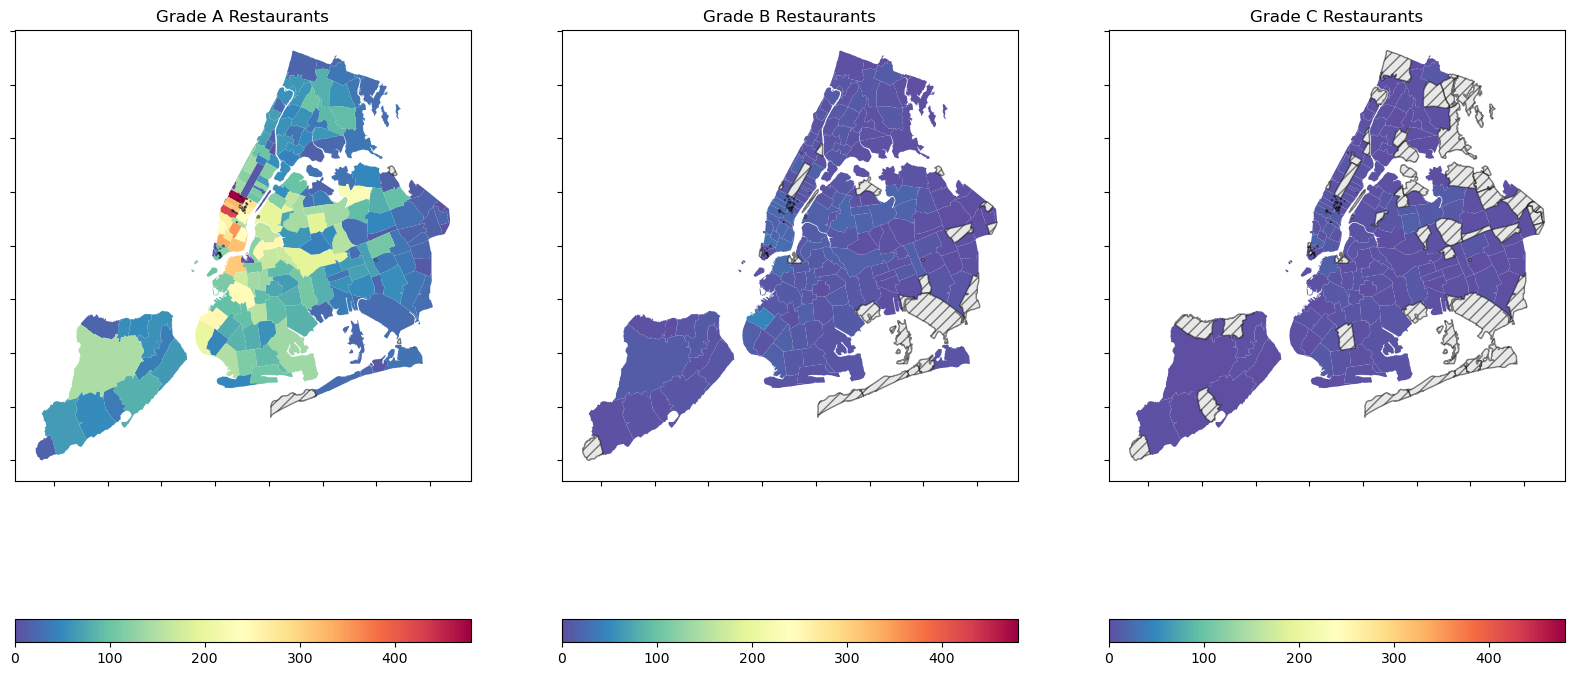

In [8]:
GRADE = ['A','B','C']
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,12))
vmin = 0
vmax = 480
for i in range(len(GRADE)):
    gradeA = grade_viz[ grade_viz.GRADE==GRADE[i] ].groupby('ZIPCODE').agg({'GRADE':'count'})
    zips.merge(gradeA,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[i],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
    ax[i].set_aspect('equal')
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_title('Grade {} Restaurants'.format(GRADE[i]) )

In [9]:
cuision_viz = geodata[geodata.GRADE.isin(['B','C'])][['CUISINE DESCRIPTION','geometry']].sjoin(zips, op='within', how='inner')
cuision_viz = cuision_viz[['CUISINE DESCRIPTION','ZIPCODE']]
cuision_viz['count'] = 1

cuision_viz = pd.pivot_table(cuision_viz,index='ZIPCODE',columns='CUISINE DESCRIPTION',aggfunc=np.sum,
               values='count',fill_value=0)

TotalCui=cuision_viz.sum(axis=1) #total violation per zip code
cuisionNormalized=cuision_viz.div(TotalCui, axis=0) #normalize violation within zip code by total
cuisionNormalized=cuisionNormalized.loc[TotalCui>10] #keep only those zip codes having sufficient violation

In [10]:

range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters: #try different numbers of cuisionNormalized
    rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(cuisionNormalized)
    rr.labels_ = rr.predict(cuisionNormalized)
    #report average Silhouette score
    silhouette_avg = silhouette_score(cuisionNormalized, rr.labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.1783557817730253
For n_clusters =3, the average silhouette_score is :0.24627408586843164
For n_clusters =4, the average silhouette_score is :0.19689164052390706
For n_clusters =5, the average silhouette_score is :0.19068396166421334


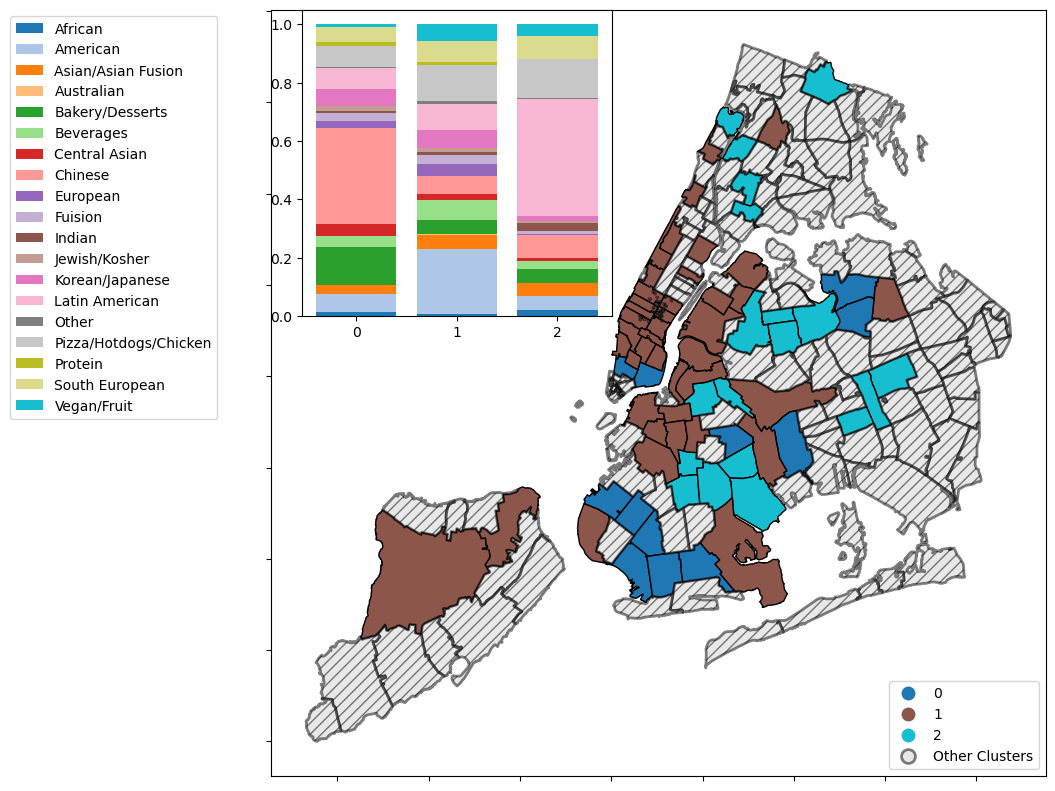

In [11]:

cluster_num = 3

rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(cuisionNormalized)
rr.labels_ = rr.predict(cuisionNormalized) #get labels
clust={cuisionNormalized.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'zipcode':cuisionNormalized.index, 'label':rr.labels_})

clusterChar = cuisionNormalized.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
spatial_plot = zips.merge(res,left_on='ZIPCODE',right_on='zipcode',how='left')
# spatial_plot['label'] = spatial_plot['label'].apply(lambda x: 'Cluster '+x)
spatial_plot.plot(column='label',  #cmap='cool', 
                    legend=True,legend_kwds={'loc':'lower right'},
                    ax=ax,edgecolor='black',missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ins = ax.inset_axes([0.04,0.6,0.4,0.4])
NUM_COLORS = len(clusterChar.columns)
cm = plt.cm.get_cmap('tab20', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(3)


for col in clusterChar.columns:
    if col!= 'label' and col!='Zip' and col!='zipcode':
        values = clusterChar[col].values
        ins.bar([0,1,2], values, bottom = bot, label=col)
        bot = bot + values
ins.set_xticks([0,1,2])    
ins.legend(bbox_to_anchor=(-0.25, 1))   

In [12]:
cuision_vizA = geodata[geodata.GRADE=='A'][['CUISINE DESCRIPTION','geometry']].sjoin(zips, op='within', how='inner')
cuision_vizA = cuision_vizA[['CUISINE DESCRIPTION','ZIPCODE']]
cuision_vizA['count'] = 1

cuision_vizA = pd.pivot_table(cuision_vizA,index='ZIPCODE',columns='CUISINE DESCRIPTION',aggfunc=np.sum,
               values='count',fill_value=0)

TotalCui=cuision_vizA.sum(axis=1) #total violation per zip code
cuisionANormalized=cuision_vizA.div(TotalCui, axis=0) #normalize violation within zip code by total
cuisionANormalized=cuisionANormalized.loc[TotalCui>10] #keep only those zip codes having sufficient violation

range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters: #try different numbers of cuisionNormalized
    rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(cuisionANormalized)
    rr.labels_ = rr.predict(cuisionANormalized)
    #report average Silhouette score
    silhouette_avg = silhouette_score(cuisionANormalized, rr.labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.20779363257706504
For n_clusters =3, the average silhouette_score is :0.17737849433872255
For n_clusters =4, the average silhouette_score is :0.14781175765779248
For n_clusters =5, the average silhouette_score is :0.14138933695483927


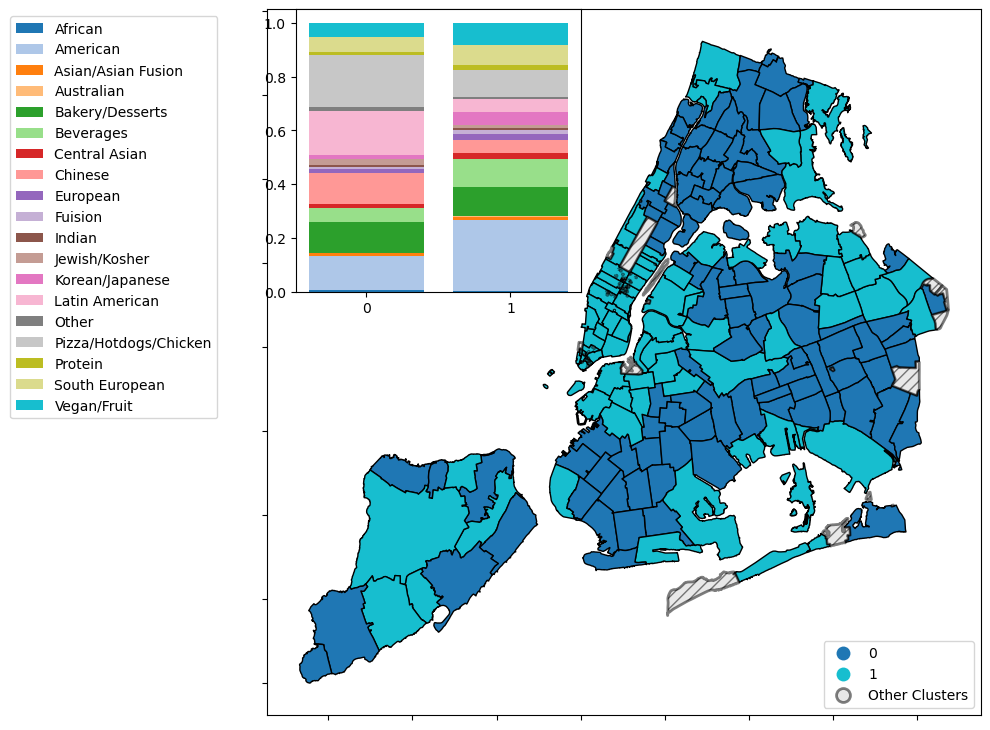

In [13]:
cluster_num = 2

rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(cuisionANormalized)
rr.labels_ = rr.predict(cuisionANormalized) #get labels
clust={cuisionANormalized.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'zipcode':cuisionANormalized.index, 'label':rr.labels_})

clusterChar = cuisionANormalized.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
spatial_plot = zips.merge(res,left_on='ZIPCODE',right_on='zipcode',how='left')
# spatial_plot['label'] = spatial_plot['label'].apply(lambda x: 'Cluster '+x)
spatial_plot.plot(column='label',  #cmap='cool', 
                    legend=True,legend_kwds={'loc':'lower right'},
                    ax=ax,edgecolor='black',missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ins = ax.inset_axes([0.04,0.6,0.4,0.4])
NUM_COLORS = len(clusterChar.columns)
cm = plt.cm.get_cmap('tab20', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(cluster_num)


for col in clusterChar.columns:
    if col!= 'label' and col!='Zip' and col!='zipcode':
        values = clusterChar[col].values
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
        bot = bot + values
ins.set_xticks([i for i in range(cluster_num)])    
ins.legend(bbox_to_anchor=(-0.25, 1))   

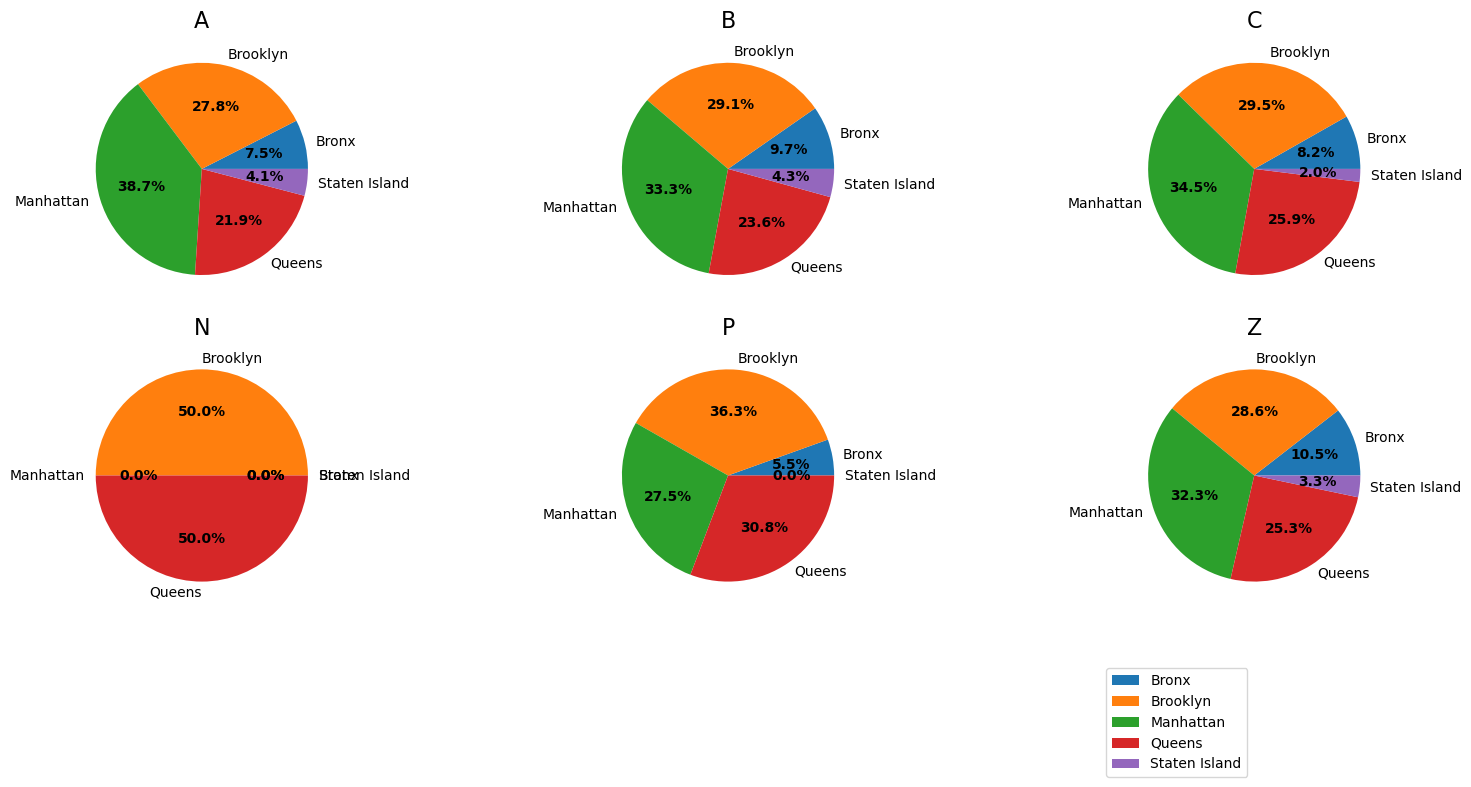

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
df = pd.read_csv("Clean_DataSet.csv")

grades_by_borough = df.groupby("BORO")["GRADE"].value_counts().unstack().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=len(grades_by_borough.columns)//2, figsize=(16, 8), subplot_kw={"aspect": "equal"})
axes = axes.flat


for i, grade in enumerate(grades_by_borough.columns):
    _, _, autotexts = axes[i].pie(grades_by_borough[grade], labels=grades_by_borough.index, autopct="%1.1f%%", textprops={"fontsize": 10})
    plt.setp(autotexts, weight="bold")
    axes[i].set_title(grade, fontsize=16)

plt.legend( bbox_to_anchor=(0.5, -0.2))

plt.show()